In [16]:
import seaborn as sns

In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER




In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor, start=160, num_days=112):
    t_subset = tensor[:, :, start:start+num_days, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, num_days*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    print(len(all_indices))
    t_subset = t_subset[all_indices, :, :, :].reshape(len(all_indices), 7, num_days*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
def create_subset_dataset(tensor, start=160, num_days=112):
    t_subset = tensor[:, :, start:start+num_days, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, num_days*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    print(len(all_indices))
    t_subset = t_subset[all_indices, :, :, :]
    
    # Create artificial aggregate
    t_subset[:, 0, :,:] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :,:] = t_subset[:, 0, :,:] + t_subset[:, i, :,:]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [6]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

52


(52, 7, 112, 24)

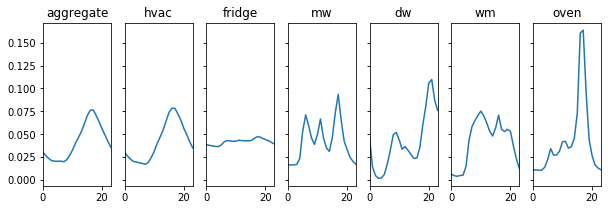

In [17]:
fig, ax = plt.subplots(ncols=7, sharey=True, figsize=(10,3))


for appliance_number, appliance in enumerate(APPLIANCES_ORDER):
    s = pd.Series(t_all[:, appliance_number, :, :].sum(axis=0).sum(axis=0))
    s.div(s.sum()).plot(ax=ax[appliance_number], title=appliance)

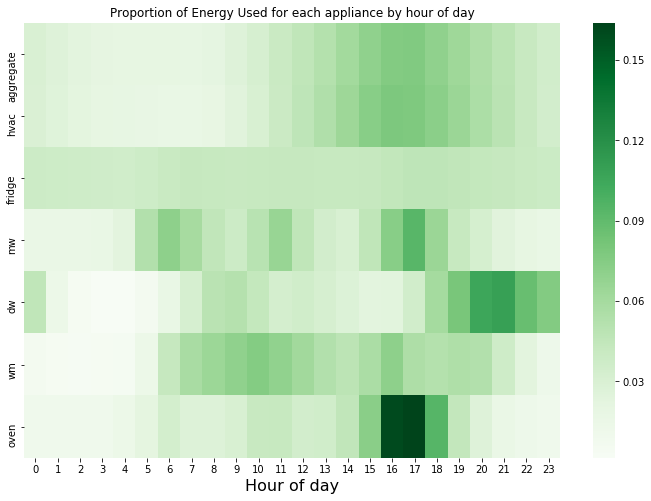

In [18]:
fig, ax = plt.subplots(nrows=1, figsize=(12,8))

out = {}

for appliance_number, appliance in enumerate(APPLIANCES_ORDER):
    s = pd.Series(t_all[:, appliance_number, :, :].sum(axis=0).sum(axis=0))
    out[appliance] = s.div(s.sum())

sns.heatmap(pd.DataFrame(out)[APPLIANCES_ORDER].T, ax=ax, cmap='Greens')
plt.xlabel("Hour of day",fontsize=16)
plt.title("Proportion of Energy Used for each appliance by hour of day")


In [19]:
o = {}
for appliance in APPLIANCES_ORDER[:]:
    o[appliance] = {}
    for home in range(52):
        
        s = pd.Series(t_all[home, APPLIANCES_ORDER.index(appliance), :, :].sum(axis=0))
        o[appliance][home]= s.div(s.sum())

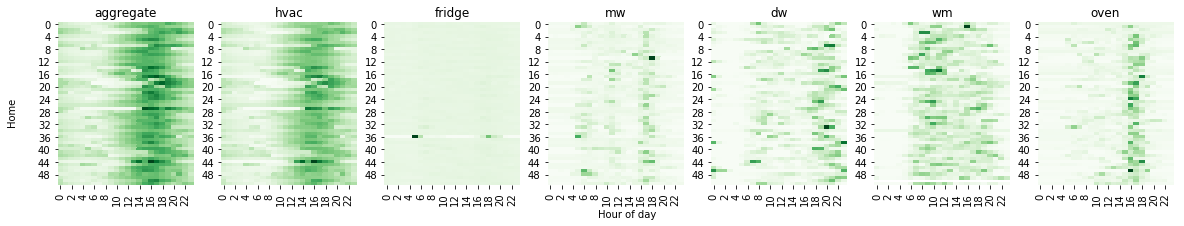

In [20]:
fig, ax = plt.subplots(ncols=7, figsize=(20,3))

for col, appliance in enumerate(APPLIANCES_ORDER):
    sns.heatmap(pd.DataFrame(o[appliance]).T, cmap='Greens',ax=ax[col],cbar=None)
    ax[col].set_title(appliance)
fig.text(0.5, -0.02, "Hour of day")
fig.text(0.09, 0.5, "Home",rotation='vertical')

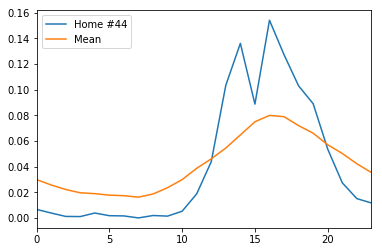

In [12]:
pd.DataFrame(o['hvac'])[44].plot(label='Home #44')
pd.DataFrame(o['hvac']).T.mean().plot(label='Mean')
plt.legend()

NameError: name 'sns' is not defined

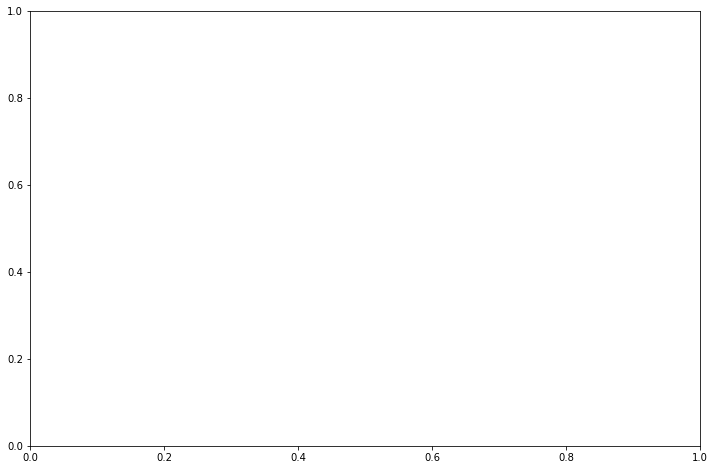

In [13]:
fig, ax = plt.subplots(nrows=1, figsize=(12,8))

out = {}

for appliance_number, appliance in enumerate(APPLIANCES_ORDER):
    s = pd.Series(t_all[0, appliance_number, :, :].sum(axis=0))
    out[appliance] = s.div(s.sum())

sns.heatmap(pd.DataFrame(out)[APPLIANCES_ORDER].T, ax=ax, cmap='Greens')
plt.xlabel("Hour of day",fontsize=16)
plt.title("Proportion of Energy Used for each appliance by hour of day")



In [31]:
d_trend = {}
for appliance_number, appliance in enumerate(APPLIANCES_ORDER):
    d_trend[appliance] = pd.DataFrame(t_all[:, appliance_number, :, :].mean(axis=1))

In [52]:
d_trend

{'aggregate':              0            1            2            3            4   \
 0    724.164286   612.417856   504.712054   441.939432   399.054614   
 1    983.818601   937.559076   872.893007   810.154165   740.006995   
 2    946.264878   858.604468   778.940924   719.672470   523.927382   
 3   1773.227526  1484.828870  1297.621876  1181.517118  1042.261010   
 4    781.066371   712.503273   658.596730   606.393004   502.677232   
 5    598.246281   521.730506   473.801338   406.051935   428.666370   
 6    576.661608   493.446580   423.224704   407.037054   378.561755   
 7   1568.925738  1372.166064  1304.954157  1002.601935   833.672621   
 8    396.075298   366.439582   330.803423   319.098957   840.096429   
 9    505.791070   444.788096   374.500595   347.124257   368.904315   
 10   674.952974   560.898811   484.775447   424.188543   383.158035   
 11   952.898368   893.563693   818.012351   756.223365   728.128421   
 12   654.235120   597.354017   520.243452   484.18

In [66]:
e = {}
ratios_appliance = {}
preds ={}
gts = {}
for appliance in APPLIANCES_ORDER[1:]:
    
    d = d_trend['aggregate'][:30].div(d_trend[appliance][:30])
    d = d.replace([np.inf, -np.inf], np.nan)
    ratios_appliance[appliance] = d.dropna().mean()
    pred = d_trend['aggregate'][30:]/d.dropna().mean()
    preds[appliance] = pred
    gt = d_trend[appliance][30:]


    gts[appliance] = gt
    err = ((gt-pred)/gt)
    err = err.replace([np.inf, -np.inf], np.nan)
    err = err.dropna()
    e[appliance] = err.abs().mean().mean()


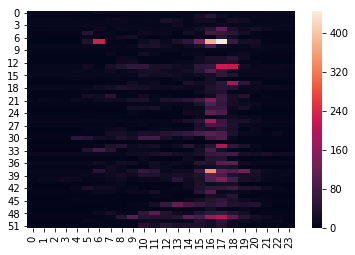

In [67]:
sns.heatmap(d_trend['oven'])

In [83]:
ratios_appliance['dw']

0       5945.738167
1       6404.443905
2       6126.740947
3     164732.704917
4      28024.215222
5       2279.120100
6       1468.344219
7        844.627946
8        737.168737
9       1490.794793
10      1234.304195
11      1016.383832
12       797.599862
13      2417.767799
14      1957.133379
15      1786.934450
16      1919.426027
17      1892.709439
18      1012.766253
19       583.593027
20      1630.458881
21      1900.734878
22      5821.467578
23      3421.716069
dtype: float64

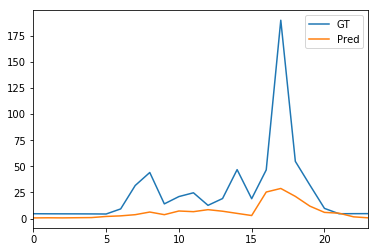

In [114]:
gts['oven'].loc[32].plot(label='GT')
preds['oven'].loc[32].plot(label='Pred')
plt.legend()

<Container object of 3 artists>

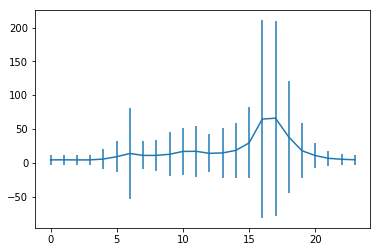

In [98]:
appliance='oven'
plt.errorbar(d_trend[appliance].mean().index, d_trend[appliance].mean(),2*d_trend[appliance].std())

<Container object of 3 artists>

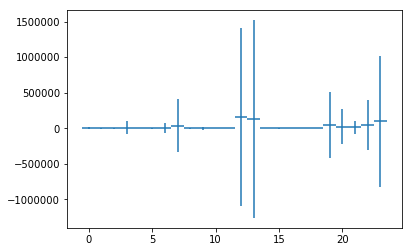

In [85]:
mean = d.mean()
std = d.std()

plt.errorbar(mean.index, mean, xerr=0.5, yerr=2*std, linestyle='')

In [117]:
mae = {}
for appliance in APPLIANCES_ORDER[1:]:
    mae[appliance] = (preds[appliance]-gts[appliance]).abs().mean().mean()
pd.Series(mae).round(1)

dw         13.6
fridge     38.0
hvac      164.8
mw          4.2
oven       14.0
wm          4.0
dtype: float64

In [15]:
fig, ax = plt.subplots(nrows=1, figsize=(12,8))

out = {}

for appliance_number, appliance in enumerate(APPLIANCES_ORDER):
    s = pd.Series(t_all[:, appliance_number, :, :].sum(axis=0).sum(axis=0))
    out[appliance] = s.div(s.sum())

sns.heatmap(pd.DataFrame(out)[APPLIANCES_ORDER].T, ax=ax, cmap='Greens')
plt.xlabel("Hour of day",fontsize=16)
plt.title("Proportion of Energy Used for each appliance by hour of day")



0     0.030836
1     0.026078
2     0.021491
3     0.018818
4     0.016992
5     0.015367
6     0.019869
7     0.022677
8     0.026022
9     0.026625
10    0.032409
11    0.041929
12    0.050472
13    0.058120
14    0.057914
15    0.057009
16    0.062172
17    0.063395
18    0.062475
19    0.073921
20    0.067383
21    0.058634
22    0.049662
23    0.039729
dtype: float64

In [100]:
c = [-1, 4]
A = [[-3, 1], [1, 2]]
b = [6, 4]
x0_bounds = (None, None)
x1_bounds = (-3, None)
from scipy.optimize import linprog
res = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds),options={"disp": True})
print(res)

Optimization terminated successfully.
         Current function value: -22.000000  
         Iterations: 1
     fun: -22.0
 message: 'Optimization terminated successfully.'
     nit: 1
   slack: array([ 39.,   0.])
  status: 0
 success: True
       x: array([ 10.,  -3.])


In [33]:
pd.DataFrame(t_all[:,3,:]).max().max()

1179.933349609375

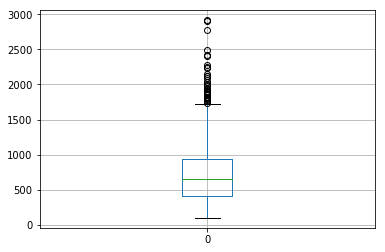

In [14]:
t = t_all[:,6,:]
t[t>100]
pd.DataFrame(t[t>100]).boxplot()

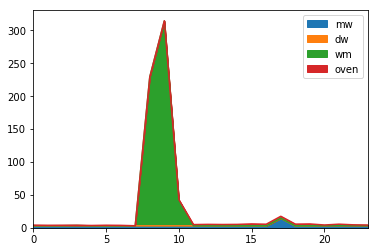

In [197]:
d.T.drop(['hvac','fridge']).T.plot(kind='area',stacked=True)

In [203]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

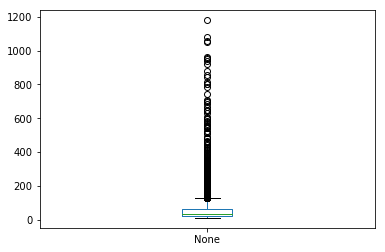

In [213]:
e = t_all[:,3,:]
pd.Series(e[e>10]).plot(kind='box')

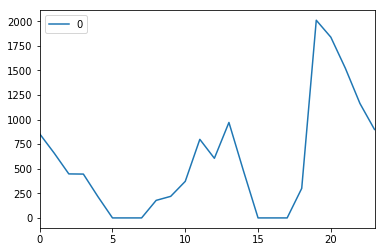

In [109]:
pd.DataFrame(t_all[0, 1, 48:72]).plot()

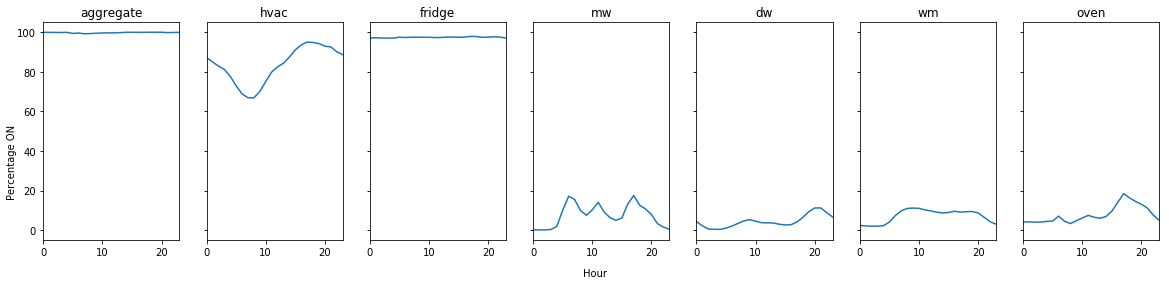

In [105]:
fig, ax = plt.subplots(ncols=7, sharey=True, figsize=(20, 4))

for appliance_num, appliance in enumerate(APPLIANCES_ORDER):
    d = pd.DataFrame(t_all[:, appliance_num, :].reshape(52*112, 24))
    pd.Series((d>10).sum()*100/len(d)).plot(title=appliance, ax=ax[appliance_num])
fig.text(0.5, 0,"Hour")
fig.text(0.10, 0.5,"Percentage ON", rotation='vertical')

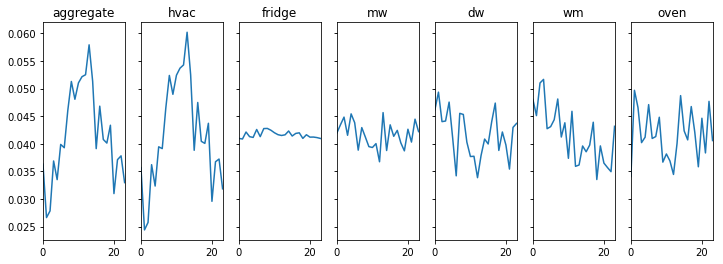

In [95]:
fig, ax = plt.subplots(ncols=7, sharey=True, figsize=(12,4))
for col, appliance in enumerate(APPLIANCES_ORDER[:]):
    s = pd.Series(t_all[:,APPLIANCES_ORDER.index(appliance),:].reshape(52, 24, -1).sum(axis=2).sum(axis=0))
    s.div(s.sum()).plot(title=appliance, ax=ax[col])

In [98]:
f = (t_all[:,APPLIANCES_ORDER.index(appliance),:].reshape(52, 24, -1) >100).astype('int')
f

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ..., 
       [[0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, 

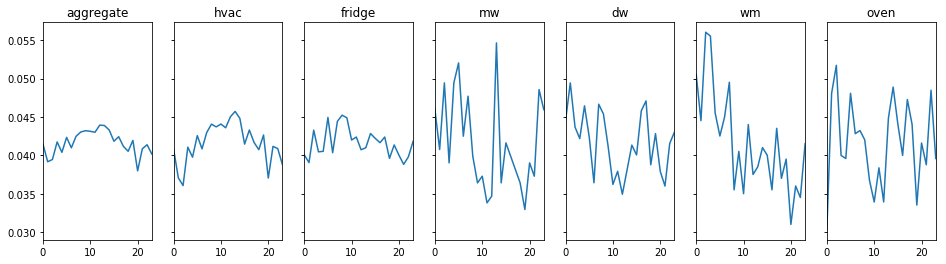

In [100]:
fig, ax = plt.subplots(ncols=7, sharey=True, figsize=(16,4))
for col, appliance in enumerate(APPLIANCES_ORDER[:]):
    s = pd.Series((t_all[:,APPLIANCES_ORDER.index(appliance),:].reshape(52, 24, -1) >100).astype('int').sum(axis=2).sum(axis=0))
    s.div(s.sum()).plot(title=appliance, ax=ax[col])

In [16]:
(pd.DataFrame(t_all[:,3,:])>20).astype('int').sum()

0       0
1       0
2       0
3       1
4       1
5       3
6       8
7      10
8       0
9       1
10      2
11      8
12      0
13      3
14      1
15      3
16     10
17     13
18      5
19      3
20      5
21      3
22      2
23      0
24      0
25      0
26      0
27      0
28      1
29      3
       ..
306     5
307     3
308     7
309     0
310     0
311     0
312     0
313     0
314     0
315     0
316     0
317     8
318    11
319     6
320     5
321     4
322     3
323     7
324     5
325     3
326     2
327     2
328     8
329     5
330     5
331     3
332     2
333     1
334     3
335     0
Length: 336, dtype: int64

In [174]:
pd.DataFrame(t_all[:, 1, :24]).mean()

0      664.772121
1      604.872755
2      483.878204
3      397.479808
4      411.038142
5      296.393591
6      431.857690
7      418.918915
8      456.648718
9      619.700003
10     699.291344
11     985.431096
12    1080.008664
13    1223.761856
14    1413.549677
15    1554.650652
16    1690.800637
17    1957.714406
18    1810.633018
19    1702.768587
20    1430.703204
21    1289.840064
22    1001.799359
23     812.321153
dtype: float64

In [176]:
pd.DataFrame(t_all[:, 1, -24:]).mean()

0      321.275640
1      266.288463
2      230.510898
3      159.307692
4      173.522756
5      211.433013
6      199.026281
7      214.029165
8      277.304164
9      415.746794
10     563.380769
11     727.949038
12     886.384614
13     992.314418
14    1203.300634
15    1556.138130
16    1782.173391
17    1623.156082
18    1565.454798
19    1415.910568
20    1232.987819
21     960.013783
22     869.475642
23     559.999361
dtype: float64

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [94]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [95]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [112]:
num_days = 112
n_train = 30
train_agg = t_all[:30, 0, :].reshape(30*num_days, 24)
train_appliance = {}
test_appliance = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    train_appliance[appliance] = t_all[:30, appliance_num+1, :].reshape(30*num_days, 24)
    test_appliance[appliance] = t_all[30:, appliance_num+1, :].reshape(22*num_days, 24)






test_hvac = t_all[30:, 1, :].reshape(22*num_days, 24)
test_fridge = t_all[30:, 2, :].reshape(22*num_days, 24)

test_mw = t_all[30:, 3, :].reshape(22*num_days, 24)



test_agg = t_all[30:, 0, :].reshape(22*num_days, 24)

In [113]:
train_hvac.shape

NameError: name 'train_hvac' is not defined

In [114]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
test_hvac_fridge = np.hstack([test_hvac, test_fridge])

NameError: name 'train_hvac' is not defined

In [156]:
pred_appliance = {}
num_iterations_dictionary = {'hvac':400,'fridge':400,'mw':250,'dw':250,'oven':250, 'wm':300}
for appliance in APPLIANCES_ORDER[1:]:
    print(appliance)
    print("*"*20)
    np.random.seed(0)
    from keras.layers.merge import Subtract, Minimum
    from keras import regularizers
    agg_input = keras.layers.Input(shape=[24],name='Aggregate')
    appliance_dense_1 = keras.layers.Dense(units=40,name='Appliance-layer-1',activation='relu')(agg_input)
    #appliance_bn = keras.layers.BatchNormalization()(appliance_dense_1)
    dropout = keras.layers.Dropout(rate=0.1,name='Droput-Appliance')(appliance_dense_1)




    out = keras.layers.Dense(units=24,name='Appliance-output',activation='relu')(dropout)
    out = Minimum(name='Clip-to-agg')([out, agg_input])


    model = keras.Model(agg_input, out)
    model.compile('adam','mean_absolute_error')
    model.fit(train_agg, train_appliance[appliance], epochs=num_iterations_dictionary[appliance], validation_split=0.1)
    pred_appliance[appliance] = model.predict(test_agg)



hvac
********************
Train on 3024 samples, validate on 336 samples
Epoch 1/400
3024/3024 [==============================] - 1s 411us/step - loss: 389.8327 - val_loss: 217.2751
Epoch 2/400
3024/3024 [==============================] - 0s 44us/step - loss: 144.0624 - val_loss: 147.9315
Epoch 3/400
3024/3024 [==============================] - 0s 46us/step - loss: 130.1580 - val_loss: 147.5591
Epoch 4/400
3024/3024 [==============================] - 0s 44us/step - loss: 129.5078 - val_loss: 147.4047
Epoch 5/400
3024/3024 [==============================] - 0s 43us/step - loss: 129.4224 - val_loss: 147.2864
Epoch 6/400
3024/3024 [==============================] - 0s 49us/step - loss: 129.4555 - val_loss: 147.1929
Epoch 7/400
3024/3024 [==============================] - 0s 45us/step - loss: 129.3131 - val_loss: 147.1357
Epoch 8/400
3024/3024 [==============================] - 0s 44us/step - loss: 129.3007 - val_loss: 147.1504
Epoch 9/400
3024/3024 [==============================] - 0s 75

In [118]:
with open('per-appliance.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



In [157]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
Appliance-layer-1 (Dense)       (None, 40)           1000        Aggregate[0][0]                  
__________________________________________________________________________________________________
Droput-Appliance (Dropout)      (None, 40)           0           Appliance-layer-1[0][0]          
__________________________________________________________________________________________________
Appliance-output (Dense)        (None, 24)           984         Droput-Appliance[0][0]           
__________________________________________________________________________________________________
Clip-to-ag

In [158]:
from sklearn.metrics import mean_absolute_error
mae = {}
for appliance in APPLIANCES_ORDER[1:]:
    try:
        mae[appliance] = mean_absolute_error(test_appliance[appliance], pred_appliance[appliance])
    except Exception as e:
        print(e)
    
    

In [165]:
pd.Series(mae)

dw         14.201703
fridge     34.803137
hvac      124.138663
mw          6.054502
oven       18.429772
wm          5.492065
dtype: float64

In [167]:
pd.Series(mae).mean()

33.85330695466527

In [146]:
pred_hvac.shape

(2464, 24)

In [168]:
pred_hvac = model.predict(test_agg)


from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_fridge))
print(mean_absolute_error(pred_hvac, test_agg))




87.0328378424
1149.5817139


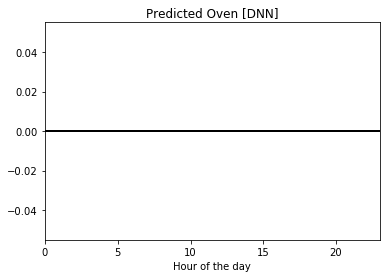

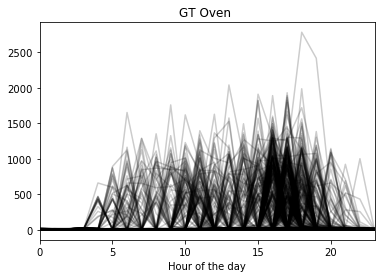

In [170]:
pd.DataFrame(pred_appliance['oven']).T.plot(legend=False, color='k',alpha=0.2)
plt.title("Predicted Oven [DNN]")
plt.xlabel("Hour of the day")
pd.DataFrame(test_appliance['oven']).T.plot(legend=False, color='k',alpha=0.2)
plt.title("GT Oven ")
plt.xlabel("Hour of the day")

In [150]:
pd.Series(test_dw[1, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(model.predict(test_agg[1:2])[0, :]).plot(label='Pred')




plt.legend()

NameError: name 'test_dw' is not defined

In [130]:
test_hvac.shape

(2464, 24)